# Аналитика интернет-магазина

Цель проекта - приоритизировать гипотезы, запустить A/B-тест и проанализировать его результаты.

**Описание данных.**


Файл /datasets/hypothesis.csv содержит:
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.


Файл /datasets/orders.csv содержит: 
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.


Файл /datasets/visitors.csv содержит:
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Изучение-данных-из-файла-и-предобработка" data-toc-modified-id="Изучение-данных-из-файла-и-предобработка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Изучение данных из файла и предобработка</a></span></li><li><span><a href="#Приоритизация-гипотез" data-toc-modified-id="Приоритизация-гипотез-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Приоритизация гипотез</a></span></li><li><span><a href="#Анализ-A/B-теста" data-toc-modified-id="Анализ-A/B-теста-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ A/B-теста</a></span></li><li><span><a href="#Выводы-и-рекомендации" data-toc-modified-id="Выводы-и-рекомендации-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы и рекомендации</a></span></li></ul></div>

## Изучение данных из файлов и предобработка

In [1]:
import pandas as pd
pd.set_option('max_colwidth', -1)
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.stats as stats
from scipy import stats as st

import math

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')

In [3]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
#изменим наименования столбцов
hypothesis = hypothesis.rename(
    columns=str.lower
)

In [5]:
#Убедимся в результате
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
hypothesis    9 non-null object
reach         9 non-null int64
impact        9 non-null int64
confidence    9 non-null int64
efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [6]:
orders = pd.read_csv('/datasets/orders.csv', sep=',')

In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [8]:
#Изменим наименования столбцов
orders.set_axis(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], axis="columns", inplace=True)

In [9]:
#Убедимся в результате
orders.info()

#В отдельно взятом датафрейме пропусков нет. Проверим на дубликаты.
orders.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transaction_id    1197 non-null int64
visitor_id        1197 non-null int64
date              1197 non-null object
revenue           1197 non-null int64
group             1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


0

In [10]:
visitors = pd.read_csv('/datasets/visitors.csv', sep=',')

In [11]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [12]:
#В отдельно взятом датафрейме пропусков нет. Проверим на дубликаты.
visitors.duplicated().sum()

0

In [13]:
#Посмотрим есть ли посетители, которые попали в обе группы. Для этого создадим таблицу, 
#в которой для каждого пользователя будет группа в которой он произвел свой первый заказ. 
#Далее посмотрим сколько есть несовпадений.

first_group_by_customer = orders.groupby('visitor_id', as_index = False).agg({'group':'first'})

orders_extra = pd.merge(orders, first_group_by_customer, left_on = ['visitor_id'], right_on = ['visitor_id'], 
                        suffixes = ['', '_first_order'])

len(orders_extra.query('group != group_first_order')['visitor_id'])

91

In [14]:
#Найден 91 заказ, которые были совершены не в "своих" группах. 
#Необходимо удалить пользователей, которые перепутались между группами, 
#так как они могли делать заказ то в одной, то в другой группе.

messed_customers_list = orders_extra.query('group != group_first_order')['visitor_id']

len(messed_customers_list.unique())

#Всего таких 58 пользователей, а сделали они 158 заказов. Нужно удалить такие

orders = orders.query('visitor_id not in @messed_customers_list.values').reset_index(drop = True)

#Теперь есть обновленная таблица, только с теми пользователями, которые совершали заказы исключительно в одной группе

# Вывод

В этом разделе была проведена предобработка данных:
- прочтены и изучены данные из файлов;
- откорректированы наименования столбцов;
- проверены на пропуски и дбуликаты.

Кроме того, проведена проверка на попадание одного и того же юзера в обе группы теста. Таких оказалось 58 пользователей. Таблица orders очищена от них. Можно дальше работать.

## Приоритизация гипотез

**2.1. Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.**

In [15]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [16]:
hypothesis['ICE'] = ((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']).round(2)
(hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Четверка  наиболее перспективных гипотез: 8, 0, 7, 6.

**2.2.Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.**

In [17]:
hypothesis['RICE'] = (hypothesis['impact'] * hypothesis['confidence'] * hypothesis['reach']) / hypothesis['efforts']
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


При расчете RICE приоритизация следующая: 7, 2, 0, 6. Причем у гипотезы №7 RICE в два раза выше, чем у гипотезы № 2. Это случилось по причине того, что показатель reach у гипотезы №7 выше всех. ТОП-5 гипотез в результате расчета ICE и RICE получился одинаковым.

## Анализ A/B-теста

**3.1. Построим график кумулятивной выручки по группам. Сделаем выводы и предположения.**

In [18]:
orders.head(10)

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,3797467345,1196621759,2019-08-15,9759,B
3,2282983706,2322279887,2019-08-15,2308,B
4,182168103,935554773,2019-08-15,2210,B
5,398296753,2900797465,2019-08-15,1860,B
6,2626614568,78758296,2019-08-15,1044,A
7,1576988021,295230930,2019-08-15,13710,A
8,1506739906,1882260405,2019-08-15,1855,B
9,3649131742,879864040,2019-08-15,4008,A


In [19]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [20]:
visitors.head(10)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


In [21]:
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,3797467345,1196621759,2019-08-15,9759,B
3,2282983706,2322279887,2019-08-15,2308,B
4,182168103,935554773,2019-08-15,2210,B


In [22]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [23]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date', 'group']].drop_duplicates()
# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': pd.Series.nunique,
            'visitor_id': pd.Series.nunique,
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])


In [24]:
# получаем агрегированные кумулятивные по дням данные о заказах 
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])


In [25]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]


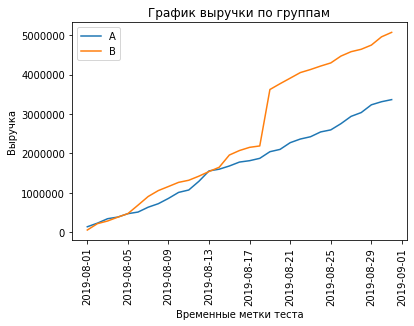

In [26]:
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('График выручки по группам')
plt.ylabel("Выручка")
plt.xlabel("Временные метки теста")
plt.xticks(rotation=90)
plt.legend();

Выручка почти равномерно увеличивается в течение всего теста. Однако графики выручки обеих групп в нескольких точках резко растут. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.

**3.2. Построим график кумулятивного среднего чека по группам. Сделаем выводы и предположения.**

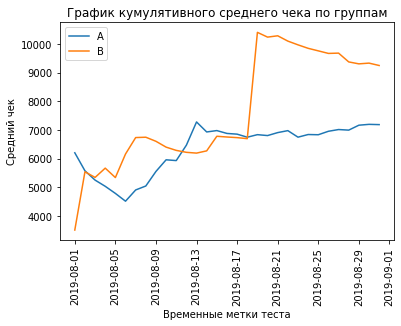

In [27]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('График кумулятивного среднего чека по группам')
plt.ylabel("Средний чек")
plt.xlabel("Временные метки теста")
plt.xticks(rotation=90)
plt.legend();

Кумулятивное значение среднего чека сильно колеблется. Требуется дополнительный анализ выбросов.

**3.3. Построим график относительного изменения кумулятивного среднего чека группы B к группе A. Сделаем выводы и предположения.**

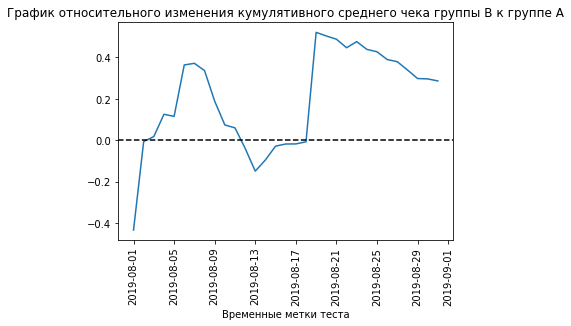

In [28]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', 
                                                   suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/
                                           mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/
                                                                                mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel("Временные метки теста")
plt.xticks(rotation=90);

С течением времени результаты теста резо и значительно менялись. Видимо, именно тогда были совершены аномальные заказы.

**3.4. Построим график кумулятивной конверсии по группам. Сделаем выводы и предположения.**

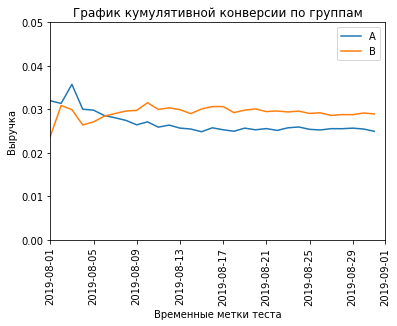

In [29]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

# передадим ему минимальное и максимальное значения оси x; минимальное и максимальное значения оси y
plt.axis(["2019-08-01", '2019-09-01', 0, 0.05])
plt.xlabel("Временные метки теста")
plt.xticks(rotation=90)
plt.title('График кумулятивной конверсии по группам')
plt.ylabel("Выручка");

В начале теста сегмент А имел большую конверсию, но постепенно сегмент В выровнялся и зафиксировался примено у одного значения, больше значения сегмента А.

**3.5. Построим график относительного изменения кумулятивной конверсии группы B к группе A. Сделаем выводы и предположения.**

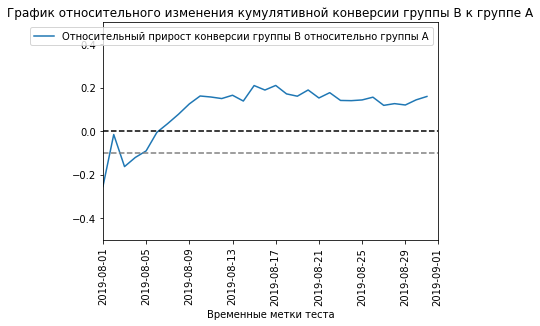

In [30]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-09-01', -0.5, 0.5])
plt.xlabel("Временные метки теста")
plt.xticks(rotation=90)
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A');

В начале теста группа B проигрывала группе A, затем вырвалась вперёд. С течением времени её конверсия снова падала, но теперь постепенно растёт.
В целом отношение конверсии ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя. Впрочем, сперва стоит проанализировать аномалии, возможно, они изменят картину.

**3.6. Построим точечный график количества заказов по пользователям. Сделаем выводы и предположения.**

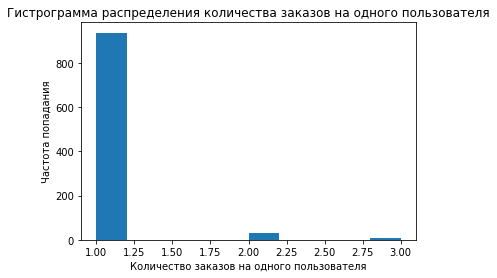

In [31]:
#построим гистрограмму распределения количества заказов на одного пользователя
ordersByUsers = (
    orders.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsers.columns = ['visitors', 'orders']

plt.hist(ordersByUsers['orders'])
plt.title('Гистограмма распределения количества заказов на одного пользователя')
plt.xlabel("Количество заказов на одного пользователя")
plt.ylabel("Частота попадания");

Большинство покупателей заказывали только один раз. Доля пользователей с 2-3 заказами незначительна.

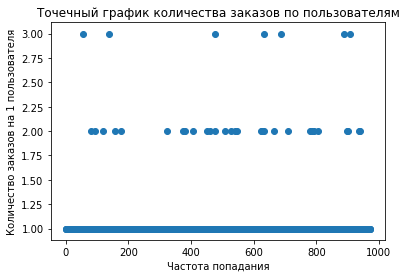

In [32]:
#Построим точечную диаграмму числа заказов на одного пользователя

#print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Tочечный график количества заказов по пользователям')
plt.ylabel("Количество заказов на 1 пользователя")
plt.xlabel("Частота попадания");

Выводы подтверждаются: основная масса пользователей с 1 заказом. Но присутствуют юзеры с 2 и 3 заказами, их точная доля не ясна — непонятно, считать их аномалиями или нет. 

**3.7. Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.**

In [33]:
#посчитаем выборочные перцентили количества заказов на одного пользователя:

print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[1. 2.]


Не более 5% пользователей оформляли больше чем 1 заказ. И не более 1% пользователей заказывали более 2х раз.
Разумно выбрать 1 заказ на одного пользователя за нижнюю границу числа заказов, и отсеять аномальных пользователей по ней. 

**3.8. Построим точечный график стоимостей заказов. Сделаем выводы и предположения.**

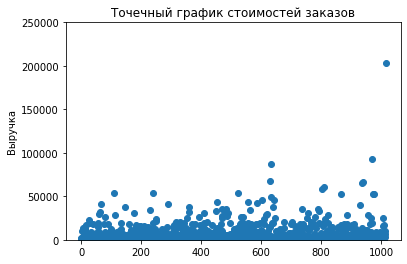

In [34]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечный график стоимостей заказов')
plt.ylim(0, 250000)
plt.ylabel("Выручка");

 Есть немного дорогих заказов. По графику можно выбрать границу аномальных заказов - выше 50 000 рублей. Однако принято отсеивать от 1% до 5% наблюдений с крайними значениями.

**3.9. Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.**

In [35]:
print(np.percentile(orders['revenue'], [95, 99])) 

[26785. 53904.]


Не более 5% заказов дороже 26785 рублей и не более 1% дороже 53904 рублей. Разумно выбрать стоимость заказа в 26785 рублей  (5%), как и по количеству заазов на 1 пользователя, за нижнюю границу числа заказов, и отсеять аномальных пользователей по ней. 

**3.10. Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным. Сделаем выводы и предположения.**

In [36]:
#Изучим код и устройство таблиц

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']



In [37]:
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]



In [38]:
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

#print(data.head(5))


In [39]:
#Посчитаем статистическую значимость различия в конверсии между группами
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitors', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitors', 'orders'] 
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, 
                                                        index=np.arange(data['visitorsPerDateA'].sum() - 
                                                                        len(ordersByUsersA['orders'])), 
                                                        name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, 
                                                        index=np.arange(data['visitorsPerDateB'].sum() - 
                                                                        len(ordersByUsersB['orders'])), 
                                                        name='orders')],axis=0)

p_value = stats.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')[1]



print("{0:.3f}".format((data['ordersPerDateB'].sum()/data['visitorsPerDateB'].sum())/(data['ordersPerDateA'].sum()
                                                                                      /data['visitorsPerDateA'].sum())-1))



0.160


In [40]:
# H0: Конверсия в группе A РАВНА конверсии в группе B
# H1: Конверсия в группе A НЕ РАВНА конверсии в группе B
alpha=0.05

print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.011018084110014691
Отвергаем нулевую гипотезу


P-value значительно меньше 0,05, поэтому нулевую гипотезу отвергаем. Анализ "сырых данных" сообщает, что в конверсии между группами есть статистиески значимые различия. Относительный прирост конверсии группы В к конверсии группы А 16%.

In [41]:
#import scipy
#scipy.__version__

**3.11. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделаем выводы и предположения.**

In [42]:
#print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

0.287


In [43]:
# Воспользуемся критерием Манна-Уитни
# H0: Средний чек A НЕ ПРЕВОСХОДИТ среднему чеку группы B
# H1: Средний чек A ПРЕВОСХОДИТ среднему чеку группы B
alpha = 0.05
pvalue = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], 
                            alternative = 'two-sided')[1]

print('p-значение: ', pvalue)
if (pvalue < alpha):
    print("Отвергаем H0: разница статистически значима")
else:
    print("Не получилось отвергнуть H0: вывод о различии сделать нельзя")

p-значение:  0.8294908998149533
Не получилось отвергнуть H0: вывод о различии сделать нельзя


P-value больше 0,05 - Не получилось отвергнуть нулевую гипотезу - статистически значимых различий в среднем чеке между группами нет. Относительное различие среднего чека между группами рано 28,7%.

**3.12. Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделаем выводы и предположения.**

In [44]:
#Примем за аномальных пользователей тех, кто совершил больше 1 заказа или совершил заказ дороже 26785 рублей. 

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 1]['visitors'],
        ordersByUsersB[ordersByUsersB['orders'] > 1]['visitors'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 26785]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

#print(abnormalUsers.head(5))
#print(abnormalUsers.shape)


In [45]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitors'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitors'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
#print('{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.174


In [46]:
# H0: Конверсия в группе A РАВНА конверсии в группе B
# H1: Конверсия в группе A НЕ РАВНА конверсии в группе B
alpha=0.05
p_value = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative = 'two-sided')[1]
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.01593020716573976
Отвергаем нулевую гипотезу


Статистическая значимость достигнута. Сегмент В значительно лучше сегмента А.

**3.13. Посчитаем  статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделаем выводы и предположения.**

In [47]:
#print('{0:.3f}'.format(stats.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A', 
#np.logical_not(orders['visitor_id'].isin(abnormalUsers)),)]['revenue'], 
#orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitor_id'].isin(abnormalUsers)),)]['revenue'],)[1]))

print("{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

-0.034


In [48]:
# Воспользуемся критерием Манна-Уитни
# H0: Средний чек A НЕ ПРЕВОСХОДИТ среднему чеку группы B
# H1: Средний чек A ПРЕВОСХОДИТ среднему чеку группы B
alpha = 0.05

pvalue = stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'], alternative = 'two-sided'
        )[1]
print('p-значение: ', pvalue)
if (pvalue < alpha):
    print("Отвергаем H0: разница статистически значима")
else:
    print("Не получилось отвергнуть H0: вывод о различии сделать нельзя")

p-значение:  0.7271286894009963
Не получилось отвергнуть H0: вывод о различии сделать нельзя


Результаты по среднему чеку практически не изменились.

**3.14. Примите решение по результатам теста и объясните его. Варианты решений: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.**

Имеющиеся факты:

-    Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.
-    Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий.
-    График различия конверсии между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту, либо зафиксировались около среднего значения.
-    График различия среднего чека колеблется: он-то и позволил нам найти аномалии. Сделать из этого графика определённые выводы нельзя.

 **Исходя из обнаруженных фактов, тест следует остановить и признать его неуспешным. Продолжать смысла нет, потому как вероятность, что при имеющихся данных сегмент B на самом деле лучше сегмента A — практически нулевая.**

## Выводы и рекомендации

Целью проекта было приоритизировать гипотезы, запустить A/B-тест и проанализировать его результаты. Для приоритизации были предоставлены гипотезы и их показатели (Reach — охват пользователей по 10-балльной шкале; Impact — влияние на пользователей по 10-балльной шкале; Confidence — уверенность в гипотезе по 10-балльной шкале; Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале). В результате применения фреймворка ICE и RICE мы получили одинаковый ТОП-5 гипотез (7, 2, 0, 6, 8).

Для проведения А/В-теста нам предоставлены данные о пользователях и их заказах. В начале анализа проведена предобработка данных и проверка корректности состава групп теста, по итогам которой были выявлены 58 пользователей, попавших в обе группы. Их удалили.

Анализ выручки по группам показал, что выручка почти равномерно увеличивается в течение всего теста, присутствуют в нескольких точках резкие скачки роста. Это произошло из-за появлении очень большого количества и дорогих заказов в выборке. В ходе проведения теста выявлено, что чаще всего на 1 пользователя приходится 1 заказ суммой до 27000 рублей. Эти значения и были выставлены границей для "чистки" данных. Однако тест на "очищенных" данных дал те же результаты, что и "сырые", а именно:

-   Есть статистически значимое различие по конверсии между группами как по "сырым" данным, так и после фильтрации аномалий;
-   Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
-   График различия конверсии между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту.

Исходя из обнаруженных фактов, тест следует остановить и признать его неуспешным. Продолжать смысла нет, потому как вероятность, что при имеющихся данных сегмент B на самом деле лучше сегмента A — практически нулевая.
